# 利用核函数处理手写识别问题
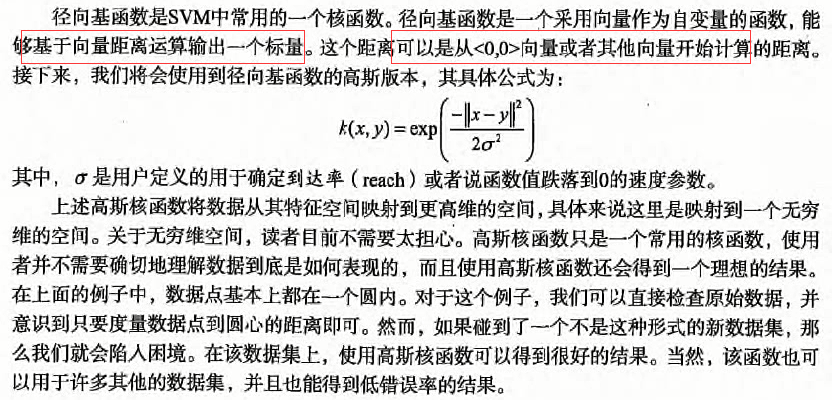

In [2]:
from numpy import *
import matplotlib.pyplot as plt

In [5]:
class optStruct:
    """
    建立的数据结构来保存所有的重要值
    """
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        """
        Args:
            dataMatIn    数据集
            classLabels  类别标签
            C   松弛变量(常量值)，允许有些数据点可以处于分隔面的错误一侧。
                控制最大化间隔和保证大部分的函数间隔小于1.0这两个目标的权重。
                可以通过调节该参数达到不同的结果。
            toler   容错率
            kTup    包含核函数信息的元组
        """

        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler

        # 数据的行数
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0

        # 误差缓存，第一列给出的是eCache是否有效的标志位，第二列给出的是实际的E值。
        self.eCache = mat(zeros((self.m, 2)))

        # m行m列的矩阵
        self.K = mat(zeros((self.m, self.m)))#核函数矩阵
        for i in range(self.m):
            self.K[:, i] = kernelTrans(self.X, self.X[i, :], kTup)

In [6]:
def kernelTrans(X, A, kTup):  # calc the kernel or transform data to a higher dimensional space
    """
    核转换函数
    Args:
        X     dataMatIn数据集
        A     dataMatIn数据集的第i行的数据
        kTup  核函数的信息

    Returns:

    """
    m, n = shape(X)
    K = mat(zeros((m, 1)))
    if kTup[0] == 'lin':
        # linear kernel:   m*n * n*1 = m*1
        K = X * A.T
    elif kTup[0] == 'rbf':
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow * deltaRow.T
        # 径向基函数的高斯版本
        K = exp(K / (-1 * kTup[1] ** 2))  # divide in NumPy is element-wise not matrix like Matlab
    else:
        raise NameError('Houston We Have a Problem -- That Kernel is not recognized')
    return K

In [8]:
def loadDataSet(fileName):
    """loadDataSet（对文件进行逐行解析，从而得到第行的类标签和整个数据矩阵）

    Args:
        fileName 文件名
    Returns:
        dataMat  数据矩阵
        labelMat 类标签
    """
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

In [14]:
#使用核函数需要对innerL()以及calcEk()进行修改
#fxk changed
def calcEk(oS, k):
    """calcEk（求 Ek误差：预测值-真实值的差）

    该过程在完整版的SMO算法中陪出现次数较多，因此将其单独作为一个方法
    Args:
        oS  optStruct对象
        k   具体的某一行

    Returns:
        Ek  预测结果与真实结果比对，计算误差Ek
    """
    fXk = float(multiply(oS.alphas, oS.labelMat).T * oS.K[:, k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [13]:
#eta，b1，b2 changed
def innerL(i, oS):
    """innerL
    内循环代码
    Args:
        i   具体的某一行
        oS  optStruct对象

    Returns:
        0   找不到最优的值
        1   找到了最优的值，并且oS.Cache到缓存中
    """

    # 求 Ek误差：预测值-真实值的差
    Ei = calcEk(oS, i)

    # 约束条件 (KKT条件是解决最优化问题的时用到的一种方法。我们这里提到的最优化问题通常是指对于给定的某一函数，求其在指定作用域上的全局最小值)
    # 0<=alphas[i]<=C，但由于0和C是边界值，我们无法进行优化，因为需要增加一个alphas和降低一个alphas。
    # 表示发生错误的概率：labelMat[i]*Ei 如果超出了 toler， 才需要优化。至于正负号，我们考虑绝对值就对了。
    '''
    # 检验训练样本(xi, yi)是否满足KKT条件
    yi*f(i) >= 1 and alpha = 0 (outside the boundary)
    yi*f(i) == 1 and 0<alpha< C (on the boundary)
    yi*f(i) <= 1 and alpha = C (between the boundary)
    '''
    if ((oS.labelMat[i] * Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i] * Ei > oS.tol) and (oS.alphas[i] > 0)):
        # 选择最大的误差对应的j进行优化。效果更明显
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()

        # L和H用于将alphas[j]调整到0-C之间。如果L==H，就不做任何改变，直接return 0
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            # print("L==H")
            return 0

        # eta是alphas[j]的最优修改量，如果eta==0，需要退出for循环的当前迭代过程
        # 参考《统计学习方法》李航-P125~P128<序列最小最优化算法>
        eta = 2.0 * oS.K[i, j] - oS.K[i, i] - oS.K[j, j]  # changed for kernel
        if eta >= 0:
            print("eta>=0")
            return 0

        # 计算出一个新的alphas[j]值
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        # 并使用辅助函数，以及L和H对其进行调整
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        # 更新误差缓存
        updateEk(oS, j)

        # 检查alpha[j]是否只是轻微的改变，如果是的话，就退出for循环。
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            # print("j not moving enough")
            return 0

        # 然后alphas[i]和alphas[j]同样进行改变，虽然改变的大小一样，但是改变的方向正好相反
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        # 更新误差缓存
        updateEk(oS, i)

        # 在对alpha[i], alpha[j] 进行优化之后，给这两个alpha值设置一个常数b。
        # w= Σ[1~n] ai*yi*xi => b = yi- Σ[1~n] ai*yi(xi*xj)
        # 所以：  b1 - b = (y1-y) - Σ[1~n] yi*(a1-a)*(xi*x1)
        # 为什么减2遍？ 因为是 减去Σ[1~n]，正好2个变量i和j，所以减2遍
        b1 = oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[i, i] - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[i, j]
        b2 = oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[i, j] - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[j, j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2.0
        return 1
    else:
        return 0

In [15]:
def selectJrand(i, m):
    """
    随机选择一个整数
    Args:
        i  第一个alpha的下标
        m  所有alpha的数目
    Returns:
        j  返回一个不为i的随机数，在0~m之间的整数值
    """
    j = i
    while j == i:
        j = int(random.uniform(0, m))
    return j


def selectJ(i, oS, Ei):  # this is the second choice -heurstic, and calcs Ej
    """selectJ（返回最优的j和Ej）

    内循环的启发式方法。
    选择第二个(内循环)alpha的alpha值
    这里的目标是选择合适的第二个alpha值以保证每次优化中采用最大步长。
    该函数的误差与第一个alpha值Ei和下标i有关。
    Args:
        i   具体的第i一行
        oS  optStruct对象
        Ei  预测结果与真实结果比对，计算误差Ei

    Returns:
        j  随机选出的第j一行
        Ej 预测结果与真实结果比对，计算误差Ej
    """
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    # 首先将输入值Ei在缓存中设置成为有效的。这里的有效意味着它已经计算好了。
    oS.eCache[i] = [1, Ei]

    # print 'oS.eCache[%s]=%s' % (i, oS.eCache[i])
    # print 'oS.eCache[:, 0].A=%s' % oS.eCache[:, 0].A.T
    # """
    # # 返回非0的：行列值
    # nonzero(oS.eCache[:, 0].A)= (
    #     行： array([ 0,  2,  4,  5,  8, 10, 17, 18, 20, 21, 23, 25, 26, 29, 30, 39, 46,52, 54, 55, 62, 69, 70, 76, 79, 82, 94, 97]), 
    #     列： array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0])
    # )
    # """
    # print 'nonzero(oS.eCache[:, 0].A)=', nonzero(oS.eCache[:, 0].A)
    # # 取行的list
    # print 'nonzero(oS.eCache[:, 0].A)[0]=', nonzero(oS.eCache[:, 0].A)[0]
    # 非零E值的行的list列表，所对应的alpha值
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:  # 在所有的值上进行循环，并选择其中使得改变最大的那个值
            if k == i:
                continue  # don't calc for i, waste of time

            # 求 Ek误差：预测值-真实值的差
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                # 选择具有最大步长的j
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:  # 如果是第一次循环，则随机选择一个alpha值
        j = selectJrand(i, oS.m)

        # 求 Ek误差：预测值-真实值的差
        Ej = calcEk(oS, j)
    return j, Ej


def updateEk(oS, k):
    """updateEk（计算误差值并存入缓存中。）

    在对alpha值进行优化之后会用到这个值。
    Args:
        oS  optStruct对象
        k   某一列的行号
    """

    # 求 误差：预测值-真实值的差
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]


def clipAlpha(aj, H, L):
    """clipAlpha(调整aj的值，使aj处于 L<=aj<=H)
    Args:
        aj  目标值
        H   最大值
        L   最小值
    Returns:
        aj  目标值
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

In [16]:
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
    """
    完整SMO算法外循环，与smoSimple有些类似，但这里的循环退出条件更多一些
    Args:
        dataMatIn    数据集
        classLabels  类别标签
        C   松弛变量(常量值)，允许有些数据点可以处于分隔面的错误一侧。
            控制最大化间隔和保证大部分的函数间隔小于1.0这两个目标的权重。
            可以通过调节该参数达到不同的结果。
        toler   容错率
        maxIter 退出前最大的循环次数
        kTup    包含核函数信息的元组
    Returns:
        b       模型的常量值
        alphas  拉格朗日乘子
    """

    # 创建一个 optStruct 对象
    oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(), C, toler, kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0

    # 循环遍历：循环maxIter次 并且 （alphaPairsChanged存在可以改变 or 所有行遍历一遍）
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0

        #  当entireSet=true or 非边界alpha对没有了；就开始寻找 alpha对，然后决定是否要进行else。
        if entireSet:
            # 在数据集上遍历所有可能的alpha
            for i in range(oS.m):
                # 是否存在alpha对，存在就+1
                alphaPairsChanged += innerL(i, oS)
                # print("fullSet, iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1

        # 对已存在 alpha对，选出非边界的alpha值，进行优化。
        else:
            # 遍历所有的非边界alpha值，也就是不在边界0或C上的值。
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                # print("non-bound, iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1

        # 如果找到alpha对，就优化非边界alpha值，否则，就重新进行寻找，如果寻找一遍 遍历所有的行还是没找到，就退出循环。
        if entireSet:
            entireSet = False  # toggle entire set loop
        elif (alphaPairsChanged == 0):
            entireSet = True
        print("iteration number: %d" % iter)
    return oS.b, oS.alphas

In [18]:
def calcWs(alphas, dataArr, classLabels):
    """
    基于alpha计算w值
    Args:
        alphas        拉格朗日乘子
        dataArr       feature数据集
        classLabels   目标变量数据集

    Returns:
        wc  回归系数
    """
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m, n = shape(X)
    w = zeros((n, 1))
    for i in range(m):
        w += multiply(alphas[i] * labelMat[i], X[i, :].T)
    return w

In [22]:
def plotfig_SVM(xArr, yArr, ws, b, alphas):
    """
    参考地址：
       http://blog.csdn.net/maoersong/article/details/24315633
       http://www.cnblogs.com/JustForCS/p/5283489.html
       http://blog.csdn.net/kkxgx/article/details/6951959
    """

    xMat = mat(xArr)
    yMat = mat(yArr)

    # b原来是矩阵，先转为数组类型后其数组大小为（1,1），所以后面加[0]，变为(1,)
    b = array(b)[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 注意flatten的用法
    ax.scatter(xMat[:, 0].flatten().A[0], xMat[:, 1].flatten().A[0])

    # x最大值，最小值根据原数据集dataArr[:, 0]的大小而定
    x = arange(-1.0, 10.0, 0.1)

    # 根据x.w + b = 0 得到，其式子展开为w0.x1 + w1.x2 + b = 0, x2就是y值
    y = (-b-ws[0, 0]*x)/ws[1, 0]
    ax.plot(x, y)

    for i in range(shape(yMat[0, :])[1]):
        if yMat[0, i] > 0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'cx')
        else:
            ax.plot(xMat[i, 0], xMat[i, 1], 'kp')

    # 找到支持向量，并在图中标红
    for i in range(100):
        if alphas[i] > 0.0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'ro')
    plt.show()

In [31]:
def testRbf(k1=1.3):
    dataArr, labelArr = loadDataSet('6.SVM/testSetRBF.txt')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1))  # C=200 important
    datMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    svInd = nonzero(alphas.A > 0)[0]
    sVs = datMat[svInd]  # get matrix of only support vectors
    labelSV = labelMat[svInd]
    print("there are %d Support Vectors" % shape(sVs)[0])
    m, n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], ('rbf', k1))

        # 和这个svm-simple类似： fXi = float(multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[i, :].T)) + b
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]):
            errorCount += 1
    print("the training error rate is: %f" % (float(errorCount) / m))

    dataArr, labelArr = loadDataSet('6.SVM/testSetRBF2.txt')
    errorCount = 0
    datMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    m, n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], ('rbf', k1))
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]):
            errorCount += 1
    print("the test error rate is: %f" % (float(errorCount) / m))

In [38]:
def img2vector(filename):
    returnVect = zeros((1, 1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0, 32 * i + j] = int(lineStr[j])
    return returnVect


def loadImages(dirName):
    from os import listdir
    hwLabels = []
    #print(dirName)
    trainingFileList = listdir(dirName)  # load the training set
    m = len(trainingFileList)
    trainingMat = zeros((m, 1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]  # take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9:
            hwLabels.append(-1)
        else:
            hwLabels.append(1)
        trainingMat[i, :] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels


def testDigits(kTup=('rbf', 10)):

    # 1. 导入训练数据
    dataArr, labelArr = loadImages('6.SVM/trainingDigits')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    svInd = nonzero(alphas.A > 0)[0]
    sVs = datMat[svInd]
    labelSV = labelMat[svInd]
    # print("there are %d Support Vectors" % shape(sVs)[0])
    m, n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], kTup)
        # 1*m * m*1 = 1*1 单个预测结果
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount) / m))

    # 2. 导入测试数据
    dataArr, labelArr = loadImages('6.SVM/testDigits')
    errorCount = 0
    datMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    m, n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], kTup)
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the test error rate is: %f" % (float(errorCount) / m))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4




no kernel
b= [[-3.06951308]]
alphas[alphas>0]= [[ 0.06516066  0.14100699  0.02551195  0.03292563  0.01500864  0.00849141
   0.05965416  0.18145102]]
shape(alphas[alphas > 0])= (1L, 8L)
[3.634009, 1.730537] -1.0
[3.125951, 0.293251] -1.0
[4.658191, 3.507396] -1.0
[3.223038, -0.552392] -1.0
[7.40786, -0.121961] 1.0
[7.286357, 0.251077] 1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


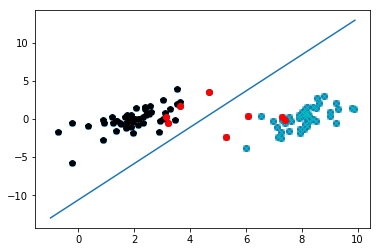





kernel
iteration number: 1
iteration number: 2
iteration number: 3
there are 21 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.010000




kernel rbf 0.1
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
the training error rate is: 0.000000
the test error rate is: 0.521505
kernel rbf 5
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
the training error rate is: 0.000000
the test error rate is: 0.032258
kernel rbf 10
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
the training error rate is: 0.000000
the test error rate is: 0.016129
kernel rbf 50
iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
the training error rate is: 0.014925
the test error rate is:

In [39]:
if __name__ == "__main__":

    # 无核函数的测试
    # 获取特征和目标变量
    dataArr, labelArr = loadDataSet('6.SVM/testSet.txt')
    # print labelArr

    # b是常量值， alphas是拉格朗日乘子
    b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40)
    print '\n\n\n'
    print 'no kernel'
    print 'b=', b
    print 'alphas[alphas>0]=', alphas[alphas > 0]
    print 'shape(alphas[alphas > 0])=', shape(alphas[alphas > 0])
    for i in range(100):
        if alphas[i] > 0:
            print dataArr[i], labelArr[i]
    # 画图
    ws = calcWs(alphas, dataArr, labelArr)
    plotfig_SVM(dataArr, labelArr, ws, b, alphas)
    
    print '\n\n\n'
    # 有核函数的测试
    print 'kernel'
    testRbf(0.8)

    # # 项目实战
    # # 示例：手写识别问题回顾
    print '\n\n\n'
    print 'kernel rbf 0.1'
    testDigits(('rbf', 0.1))
    
    print 'kernel rbf 5'
    testDigits(('rbf', 5))
    
    print 'kernel rbf 10'
    testDigits(('rbf', 10))
    
    print 'kernel rbf 50'
    testDigits(('rbf', 50))
    
    print 'kernel rbf 100'
    testDigits(('rbf', 100))